# Linear Regression using borch Borch
In this notebook we will have a look at how borch can be used in a simple linear regression setting. We will start off by generating some fake data and construct a model that we will sample from. After that we will try to reconstruct it and see if we can infer the parameters.

## Generating the data

In [1]:
from borch import borch
from borch import infer
from borch.utils.torch import optim
from borch.utils.torch import tensor_utils
import borch
import torch
import numpy as np
import matplotlib.pyplot as plt
import borch.borch.distributions as dist 


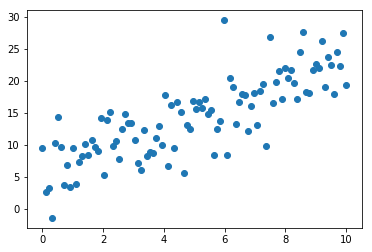

In [2]:
def generate_dataset(n=100):
    x = np.linspace(0, 10, n)
    y = 2*x+4+np.random.normal(0, 4, n)
    return torch.tensor(y, dtype=torch.float32), torch.tensor(x, dtype=torch.float32)

y, x = generate_dataset(100)
plt.scatter(x, y)
plt.show()

## Defining the model
In this section we will define the forward pass of the model which for all practical purposes is the model.

In [3]:
def forward(bm, x):
    bm.b = borch.RandomVariable(dist.Normal(0, 3))
    bm.a = borch.RandomVariable(dist.Normal(0, 3))
    # bm.sigma = borch.RandomVariable(dist.Gamma(3, 1))
    bm.sigma = borch.RandomVariable(dist.LogNormal(1, 1))
    mu = bm.b * x + bm.a
    bm.y = borch.RandomVariable(dist.Normal(mu, bm.sigma))
    return bm.y

model = borch.nn.Module()
model.observe(y=y)
optimizer = optim.OptimizersCollection(optimizer=torch.optim.Adam, lr=0.01, amsgrad=True)

For fitting the model we will use variational inference. We are running 1000 epochs and taking 10 samples of the parameters in each epoch that we then use to run the update with.

In [4]:
for e in range(1000):
    loss = 0
    subsamples = 10
    for s in range(subsamples):
        model.sample()
        yhat = forward(model, x)
        loss += infer.vi_loss(**model.pq_to_infer())
    loss.backward()
    tensor_utils.clip_gradient(model.parameters(), -1, 1)
    optimizer.step(model.parameters())
    optimizer.zero_grad()
    
    if e % 100 == 0: print("Loss: {}".format(loss))

Loss: 51509.54296875
Loss: 4675.7470703125
Loss: 3870.507080078125
Loss: 3487.099609375
Loss: 3495.619140625
Loss: 3779.28955078125
Loss: 3462.62255859375
Loss: 3305.761962890625
Loss: 3586.00146484375
Loss: 3875.182861328125


## Visualization
We also want to inspect what happened to our model visually and verify that it actually learned something. In this case we just plot the raw data and the inferred regression lines from the model by sampling the posterior.

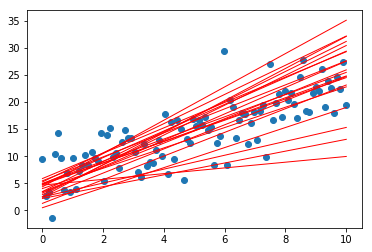

In [8]:
plt.scatter(x, y)
for i in range(20):
    ynew = model.guide["b"].sample() * x + model.guide["a"].sample()
    plt.plot(x.data.numpy(), ynew.data.numpy(), 'r-', linewidth=1.0)


We would also like to have a look at the posterior distribution for the a and b parameter. In this case we sample 2000 samples from the a and b independently and pretend that they are from the joint posterior. We also indicate in the plot where the original model was generated from.

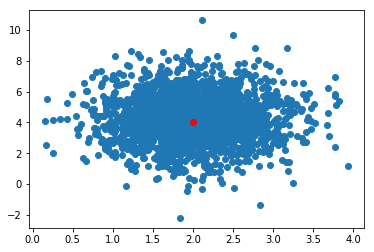

In [7]:
plt.scatter([model.guide["b"].sample().data.numpy().item() for i in range(2000)], 
            [model.guide["a"].sample().data.numpy().item() for i in range(2000)])
plt.plot([2], [4], 'ro')
plt.show()
